**CONTENT**

In this notebook we will create stochastic simulations based on either `COVID19_SEIRD_sto` or `COVID19_SEIRD_sto_spatial` with various *initial conditions* and *imposed measures*.

**OPEN TASKS**

*short term*
1. ~~Define some interesting realistic and/or artificial initial conditions~~
2. Define some interesting realistic and/or artificial imposed measures
3. Initiate the models and create a readable environment to make nice plots (create some definitions?)
4. Compare the dynamics and results of the spatially stratified model with the national model (these should largely correspond with each other)
5. Choose the most pertinent conditions and measures for plotting in geopandas and make a full-resolution video of the simulation
6. ~~Plot infections, hospitalisations and deaths~~
7. *Important*: Compare with actual data
8. Automate the hard-code in `models.py` line `coordinates = [read_coordinates_nis(spatial='test')]`
9. ~~Find a nice way to show upper and lower percentiles~~

*long term*  
1. Implement the functions in the `utils.py` environment
2. Take out the most relevant results and summarise in a $\LaTeX$ presentation
3. Include age-stratification for the mobility matrix $P^{gh}$
4. Include spatial stratification for the mobility parameter $p_i$: simulate negative travel advice
5. Include age stratification for *all* hospital parameters (including average number of days in the hospital)
6. Visualise the measures
7. Include framework for vaccination
8. Allow for fractional infection from mildly symptomatic people that ignore safety regulations (self-isolation), preferably based on research
9. Show age distribution in the relevant time series at any time
10. Fix the percentile problem: right now we are taking the percentiles for every time value, but independent simulations might cross each other. This is therefore not strictly correct (this is a detail though)

**OPEN QUESTIONS**

1. What is the reason for and the meaning of the normalisation factor $z_i$ in `COVID19_SEIRD_sto_spatial`?
2. Is it OK for all susceptibility factors $s_i$ to be smaller than one, as is the case now?
3. Can we simulate home isolation within this framework? If the contact matrix $N_{c,ij}$ is set to only $N_{home,ij}$, this still assumes homogeneity within each patch. One than still has contact with the entire patch, which is not realistic
4. Only professional commuting is included, but presumably this is not sufficient. Can we use these simulations to verify that?
5. Why are there so few hospitalisations compared to the number of deaths? There is definitely a bug there somewhere: the number of ICUs is even larger than the number of hospitalisations, which cannot be correct.
    * Probably because `H_in` literally shows how many new people get in at any day (flux only), while for example `ICU` shows how many people are *actively* occupying ICU beds. Of course there is a crucial difference between the two.

# Load packages

In [41]:
# This is copied from 0.1-mrollier-spatial-stochastic
# Not all packages may be needed

import random
import os
import numpy as np
import json
import corner # make beautiful corner plots for demonstrating the parameter distributions
import random
import os

import pandas as pd
import geopandas as gp
import datetime
import scipy
import matplotlib
import matplotlib.colors as colors
import matplotlib.dates as mdates # sophisticated date plotting capabilities
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import emcee # Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (**MCMC**) Ensemble sampler
import matplotlib.pyplot as plt

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import name2nis, read_coordinates_nis, read_areas, read_pops, dens_dep, MC_sim, draw_sample_COVID19_SEIRD # New function that translates names to NIS codes
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Geopandas shapefiles
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics

# Load different geographical aggregations
maps_dir = '../data/raw/geopandas/BE/'

country = gp.read_file(os.path.join(maps_dir, 'AD_6_Country.shp'))
regions = gp.read_file(os.path.join(maps_dir, 'AD_5_Region.shp'))
provinces = gp.read_file(os.path.join(maps_dir, 'AD_4_Province.shp'))
arrondissements = gp.read_file(os.path.join(maps_dir, 'AD_3_District.shp'))
municipalities = gp.read_file(os.path.join(maps_dir, 'AD_2_Municipality.shp'))
testgeo = arrondissements.loc[arrondissements['NISCode'].isin(['11000', '21000', '44000'])].reset_index(drop=True)

# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'

# Initialisation of the model

## Oversight of various model conditions

Any of the conditions below are implemented for both the spatial and the national stochastic SEIRD-extended model.

**Initial conditions**
1. One exposed person on day 0. With some spatial variation:  
    1. On the far southeast side of the country  
    2. On the far northwest side of the country  
    3. In Brussels  
2. Fifty exposed people on day 0, same spatial variation
3. Only asymptomatic people instead of exposed people
4. Only presymptomatic people instead of exposed people
5. No mobility whatsoever (sanity check, can only be done in spatial model)

**Measures**
1. Decrease overall contact parameter: type of contact stays the same, but the frequency is lowered
2. Change *type* of contact: only remain home contact (but note that this does not mean that families are isolated!)
3. Decrease mobility between cities (can only be done in spatial model)
4. Vaccination: migrate the number of Susceptible straight to the Recovered category

**Spatial levels**
1. 'Test' level: only arrondissements Antwerpen, Brussel, Gent
2. Arrondissement level: 43 arrondissements
3. Province level: 10+1 provinces
4. National level: no spatial stratification

## Initialisation definition

In [43]:
#################
# CONTROL PANEL #
#################

# ---------------------------- #
# Choose stratification levels #
# ---------------------------- #

age_str = True
spatial_str = 'test' # Choice between test, arr, prov or None.
# Note: changing spatial_str in general means I also have to go in the models.py code
# and change "coordinates = [read_coordinates_nis(spatial='test')]"

# ------------------------ #
# Choose initial infectors #
# ------------------------ #

init_type = 'E' # Choice between E, I or A
init_number = 50
init_place = 1 # ordered per NIS number
init_age = 3 # must be 0 if age_str = False

# ------------------------------------------ #
# Choose initial mobility and contact values #
# ------------------------------------------ #

intensity = 'all' # Choice between 'all', 'physical_only', 'less_5_min', 'more_5_min', less_15_min',
                    # 'more_15_min', 'more_one_hour', 'more_four_hours'
pi = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1.]) # pi = np.array([1.])

# ---------------------------- #
# Choose simulation parameters #
# ---------------------------- #

sim_number = 500
days_number = 100

# ------------------------------ #
# Define social inertia function #
# ------------------------------ #

# Delayed ramp 2
def social_policy_func(t,param,policy_time,policy1,policy2,ll,tau):
    if t < policy_time:
        return policy1
    else:
        tt = t-policy_time
        if tt <= tau:
            return policy1
        if (tt > tau) & (tt <= tau + ll):
            intermediate = (policy2 - policy1) / ll * (tt - tau) + policy1
            return intermediate
        if tt > tau + ll:
            return policy2

# Parameter values
ll = 5
tau = 5

# Policy values (for more details on nature of measures, see block below)
policy_time = 40 # Must be smaller than days_number

#################
# CONTROL PANEL #
#################

In [45]:
# Fetch model parameters
params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str, spatial=spatial_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial=spatial_str)

# Include additional parameters
params.update({'ll': ll,
              'tau': tau})

# Define nature of measures
params.update({'policy1': Nc_total, # No restrictions
          'policy2': Nc_home, # Everyone in home isolation
          'policy_time': policy_time})

# Update mobility parameter
params.update({'pi': pi})

# Define initial demography
N = len(params['Nc'])
G = 1
if spatial_str:
    G = len(params['place'][0])

if age_str==False:
    initN_dummy = np.zeros([G,N])
    for g in range(G):
        initN_dummy[g,0] = initN.sum(axis=1)[g]
    initN = initN_dummy
    
# Set initial states
E = np.zeros([G,N])
I = np.zeros([G,N])
A = np.zeros([G,N])
pop_dict = dict({'E' : E, 'I' : I, 'A' : A})

# Set initial infectors
pop_dict[init_type][init_place,init_age] = init_number
init_states = {'S': initN, init_type : pop_dict[init_type]}

# Load the model
if spatial_str:
    model = models.COVID19_SEIRD_sto_spatial(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                         discrete=True)
else:
    model = models.COVID19_SEIRD_sto(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                         discrete=True)

In [46]:
# Make sim_number simulations of the model and show the results
# Note: computationally expensive

#out = MC_sim(model, sim_number, days_number)
out

<xarray.Dataset>
Dimensions:   (MC: 500, Nc: 9, place: 3, time: 101)
Coordinates:
  * place     (place) int64 11000 21000 44000
  * Nc        (Nc) int32 0 1 2 3 4 5 6 7 8
  * time      (time) int32 0 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
Dimensions without coordinates: MC
Data variables:
    S         (MC, place, Nc, time) float64 1.256e+05 1.256e+05 ... 3.334e+04
    E         (MC, place, Nc, time) float64 0.0 0.0 1.0 1.0 ... 2.0 2.0 2.0 1.0
    I         (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 4.0 1.0 1.0 2.0
    A         (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 6.0 7.0 6.0 4.0
    M         (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 16.0 15.0 13.0
    ER        (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 3.0 3.0 4.0 3.0
    C         (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 6.0
    C_icurec  (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 2.0 2.0 3.0 3.0
    ICU       (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 4.0 4.0 3.0 3.0
    R         (MC, place, Nc, time) float64 0.0 0.0 0.0 ... 778.0 780.0 784.0
    D         (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 67.0 67.0 67.0
    H_in      (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 1.0
    H_out     (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 0.0
    H_tot     (MC, place, Nc, time) float64 0.0 0.0 0.0 0.0 ... 11.0 11.0 12.0
Attributes:
    parameters:  {'beta': 0.03492, 'sigma': 3.2, 'omega': 2.0, 'zeta': 0.0, '...

# Plotting

## Plotting in graph

Saved figure test_21000_500-simulations_linear_90-pct.jpg                    


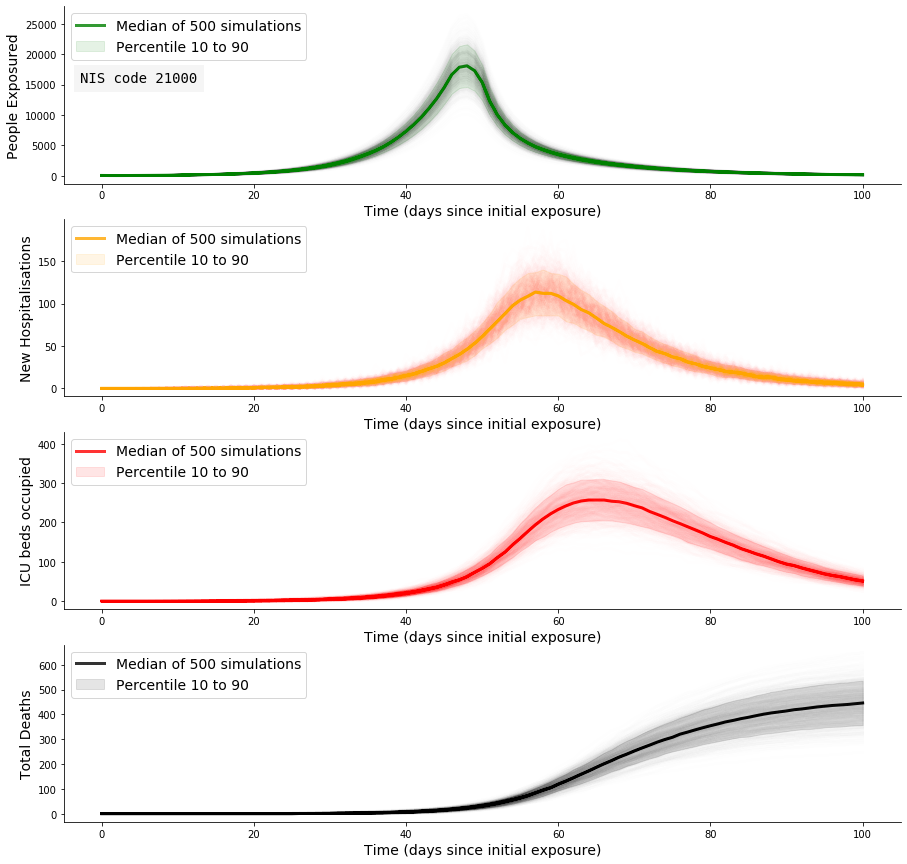

In [51]:
# Plot the results in a graph

#################
# CONTROL PANEL #
#################

# -------------- #
# Save functions #
# -------------- #

savefig = True
dpi=100
nis = 21000

# ---------- #
# Aesthetics #
# ---------- #

text_size = 14
yscale = 'linear' # symlog or linear
alpha=1/sim_number

# Uncertainty percentiles
upper_pct = 90
lower_pct = 100 - upper_pct

# Automatic figure name
cumsum_or_daily = 'daily'
figname = spatial_str + '_' + str(nis) + '_' + str(sim_number) + '-simulations_' + yscale + '_' + str(upper_pct) + '-pct' + '.jpg'

#################
# CONTROL PANEL #
#################

# Make a dictionary of time series of infections, hospitalisations and deaths for each simulation
NISlist = out['place'].values
tlist = out['time'].values
ts_list = ['E', 'H_in', 'ICU', 'D']

# Initiate figure environment

fig1, (f1_ax1, f1_ax2, f1_ax3, f1_ax4) = plt.subplots(4, 1, figsize=(15,15))
f1_ax_dict = dict({'E' : f1_ax1, 'H_in' : f1_ax2, 'ICU' : f1_ax3, 'D' : f1_ax4})
color_dict = dict({'E' : 'g', 'H_in' : 'orange', 'ICU' : 'red', 'D' : 'k'})
for ax in [f1_ax1, f1_ax2, f1_ax3, f1_ax4]:
    ax.grid(False)
    ax.set_yscale(yscale)
    ax.set_xlabel('Time (days since initial exposure)', size=text_size)
f1_ax1.set_ylabel('People Exposured', size=text_size)
f1_ax2.set_ylabel('New Hospitalisations', size=text_size)
f1_ax3.set_ylabel('ICU beds occupied', size=text_size)
f1_ax4.set_ylabel('Total Deaths', size=text_size)

plt.figtext(0.14, .81, 'NIS code ' + str(nis), backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)


for ts in ts_list:
    
    # Define lines to plot
    ts_median = out[ts].sel(place=nis).sum(dim='Nc').quantile(0.5, dim='MC').values
    ts_lower = out[ts].sel(place=nis).sum(dim='Nc').quantile(lower_pct/100, dim='MC').values
    ts_upper = out[ts].sel(place=nis).sum(dim='Nc').quantile(upper_pct/100, dim='MC').values
    
    # Prepare the axes
    ax = f1_ax_dict[ts]
    label1 = 'Median of ' + str(sim_number) + ' simulations'
    label2 = 'Percentile ' + str(lower_pct) + ' to ' + str(upper_pct)
    
    # Plot the median and the percentile region
    ax.plot(tlist, ts_median, color=color_dict[ts], alpha=0.8, linewidth=3, label=label1)
    ax.fill_between(tlist, ts_lower, ts_upper, color=color_dict[ts], alpha=0.1, label=label2)
    ax.legend(loc=2,prop={'size': text_size})
    
    # Plot all the simulations
    for i in range(sim_number):
        print(f'Plotting simulation number {i+1}/{sim_number} for timeseries {ts}     \r', end="")
        ts_sim = out[ts].sel(place=nis, MC=i).sum(dim='Nc')
        ax.plot(tlist, ts_sim, color=color_dict[ts], alpha=alpha)
            
if savefig:
    # Save figure
    plt.savefig(figname, dpi=dpi, bbox_inches='tight')
    print('Saved figure ' + figname + ' '*20)

## Plotting in Geopandas

### Geopandas-and-plots for test case

In [102]:
out.sum(dim='Nc').quantile(0.5, dim='MC')['D'].sel(place=21000, time=60).values

array(119.)

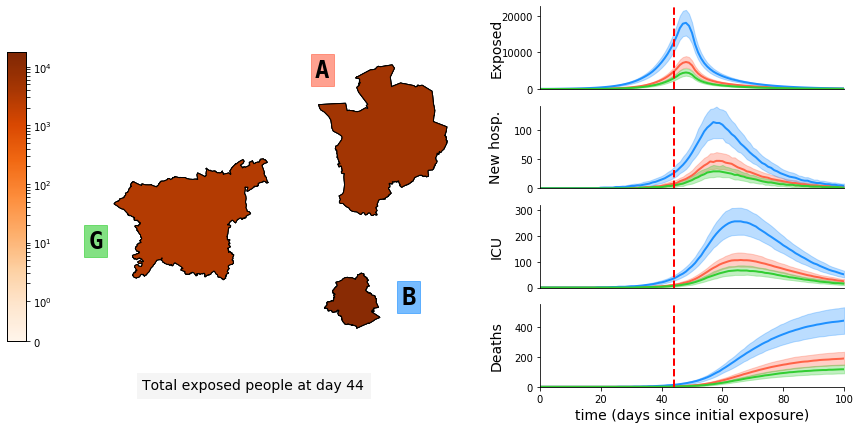

In [145]:
#################
# CONTROL PANEL #
#################

# -------------- #
# Save functions #
# -------------- #

savefig = False
dpi=100

# ------------------------------- #
# Choose map and graph parameters #
# ------------------------------- #

ts_geo = 'E' # either 'E', 'H_in', 'ICU' or 'D'
yscale_geo = 'symlog' # symlog or linear
yscale_graph = 'linear' # symlog or linear
plot_alpha = True
text_size = 14
alpha=1/sim_number
ylabel_pos = (-0.12,0.5)
upper_pct = 90
lower_pct = 100-upper_pct

# Choose to plot the absolute number, or the numbers per 100k inhabitants
abs_or_rel = 'abs'

# Automatic figure name
figname = spatial_str + '_geopandas-and-time-series_simulation_' + yscale_geo + '-' + yscale_graph

#################
# CONTROL PANEL #
#################


# Use gridspec for nicely ordered plotting
import matplotlib.gridspec as gridspec

color_dict = dict({11000 : 'tomato', 21000 : 'dodgerblue', 44000 : 'limegreen'})
cmap = 'Oranges'

# Initialise new column in geopandas dataframe
testgeo.loc[:,ts_geo] = 0

# Set minima/maxima dictionary
vmax = dict({})
for ts in ts_list:
    vmax[ts] =  out[ts].sum(dim='Nc').quantile(0.5, dim='MC').values.max()
vmin = 0


for t in tlist[44:45]:
    
    # verbose
    print(f'Working on day {t+1}/{tlist[-1]}\r', end="")

    # Initiate figure environment
    fig2 = plt.figure(figsize=(15,7))
    gs = fig2.add_gridspec(4, 2, width_ratios=[3,2])

    # Axes for Geopandas
    f2_ax0 = fig2.add_subplot(gs[:, 0])
    f2_ax0.set_axis_off()
    cax = make_axes_locatable(f2_ax0).append_axes("left", size="5%", pad=1) # Legend properties

    # Axes for graphs
    f2_ax1 = fig2.add_subplot(gs[0,1])
    f2_ax1.set_ylabel('Exposed', size=text_size)
    f2_ax1.yaxis.set_label_coords(ylabel_pos[0], ylabel_pos[1])
    f2_ax2 = fig2.add_subplot(gs[1,1])
    f2_ax2.set_ylabel('New hosp.', size=text_size)
    f2_ax2.yaxis.set_label_coords(ylabel_pos[0], ylabel_pos[1])
    f2_ax3 = fig2.add_subplot(gs[2,1])
    f2_ax3.set_ylabel('ICU', size=text_size)
    f2_ax3.yaxis.set_label_coords(ylabel_pos[0], ylabel_pos[1])
    f2_ax4 = fig2.add_subplot(gs[3,1])
    f2_ax4.set_ylabel('Deaths', size=text_size)
    f2_ax4.yaxis.set_label_coords(ylabel_pos[0], ylabel_pos[1])
    
    f2_ax_dict = dict({'E' : f2_ax1, 'H_in' : f2_ax2, 'ICU' : f2_ax3, 'D' : f2_ax4})
    
    for ts in ts_list:
        ax = f2_ax_dict[ts]
        ax.set_yscale(yscale_graph)
        ax.grid(False)
    f2_ax4.set_xlabel('time (days since initial exposure)',size=text_size)
    
    
    for nis in NISlist:
        # Plot geopandas
        ts_median_today = out.sel(place=nis, time=t).sum(dim='Nc').quantile(0.5, dim='MC')[ts_geo].values
        testgeo.loc[testgeo['NISCode']==str(nis), ts_geo] = ts_median_today
        if yscale_geo == 'symlog':
            testgeo.plot(column=ts_geo, ax=f2_ax0, cmap=cmap,legend=True, edgecolor = 'k',
                     norm=colors.SymLogNorm(linthresh=1, vmin=vmin, vmax=vmax[ts_geo]), cax=cax, alpha=1)
        elif yscale_geo == 'linear':
            testgeo.plot(column=ts_geo, ax=f2_ax0, cmap=cmap,legend=True, edgecolor = 'k',
                     vmin=vmin, vmax=vmax[ts_geo], cax=cax, alpha=1)
    
        # Plot graph
        for ts in ts_list:
            ts_median = out[ts].sel(place=nis).sum(dim='Nc').quantile(0.5, dim='MC').values
            ts_lower = out[ts].sel(place=nis).sum(dim='Nc').quantile(lower_pct/100, dim='MC').values
            ts_upper = out[ts].sel(place=nis).sum(dim='Nc').quantile(upper_pct/100, dim='MC').values
            ax = f2_ax_dict[ts]
            label = 'Median of ' + str(sim_number) + ' simulations'
            ax.plot(tlist, ts_median, color=color_dict[nis], alpha=1, linewidth=2)
            ax.set_xlim([0,len(tlist)-1])
            if yscale_graph == 'symlog':
                ax.set_ylim([vmin,10*vmax[ts]])
            else:
                ax.set_ylim([vmin,1.25*vmax[ts]])
            if ax != f2_ax4:
                ax.set_xticks([])
            if plot_alpha:
                ax.fill_between(tlist, ts_lower, ts_upper, color=color_dict[nis], alpha=0.3)
    for ax in [f2_ax1, f2_ax2, f2_ax3, f2_ax4]:
        ax.axvline(t, color='r', linewidth=2, linestyle='--')
        
    # Add metadata
    plt.figtext(.25, .12, 'Total exposed people at day ' + str(t), backgroundcolor='whitesmoke', fontsize=14)
#     plt.figtext(.37, .72, 'Antwerpen', fontsize=12).set_bbox(dict(color=color_dict[11000], alpha=0.6))
#     plt.figtext(.48, .30, 'Brussel', fontsize=12).set_bbox(dict(color=color_dict[21000], alpha=0.6))
#     plt.figtext(.20, .42, 'Gent', fontsize=12).set_bbox(dict(color=color_dict[44000], alpha=0.6))

    plt.figtext(.41, .74, 'A', fontsize=24, fontfamily='monospace', weight='bold').set_bbox(dict(color=color_dict[11000], alpha=0.6))
    plt.figtext(.49, .29, 'B', fontsize=24, fontfamily='monospace', weight='bold').set_bbox(dict(color=color_dict[21000], alpha=0.6))
    plt.figtext(.20, .40, 'G', fontsize=24, fontfamily='monospace', weight='bold').set_bbox(dict(color=color_dict[44000], alpha=0.6))
        
    if savefig:
        # Save figure
        savename = figname + str(t) + '.jpg'
        plt.savefig(savename, dpi=dpi, bbox_inches='tight')
        print('Saved figure ' + savename + ' '*20)
        
#     plt.close('all')